In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import json

from evaluation.eval_pipeline import run_evaluation_pipeline

def json_to_dataframe(data, data_type='medical'):
    rows = []

    for top_key, sample in data.items():
        is_train = top_key.startswith("train")

        def process_category(category, label):
            if category in sample:
                for condition, metrics in sample[category].items():
                    target = metrics.get('target_prob', None)

                    world_models = metrics.get('world_models', [])
                    if world_models:
                        avg_world = sum(world_models) / len(world_models)
                    else:
                        avg_world = None 

                    shadow_models = metrics.get('shadow_models', [])
                    if shadow_models:
                        avg_shadow = sum(shadow_models) / len(shadow_models)
                    else:
                        avg_shadow = None  

                    ents_prob = metrics.get('ents_prob', None)
                    len_ents_prob = len(ents_prob.keys())

                    rows.append([condition, target, avg_world, avg_shadow, label, len_ents_prob])

        if is_train:
            process_category('y_stars', 1)
        else:
            process_category('y_stars', 0)

        process_category('y_NON_stars', 0)
    if data_type == 'law':
        df = pd.DataFrame(rows, columns=['legal_text', 'target', 'world_model', 'shadow_model', 'label', 'num_ents'])
    elif data_type == 'medical':    
        df = pd.DataFrame(rows, columns=['condition', 'target', 'world_model', 'shadow_model', 'label', 'num_ents'])
    return df

with open(f"medical/probs/llama_1_epoch_world_probs_prompt_2.json") as f:
    data = json.load(f)

    results_pre = json_to_dataframe(data, data_type='medical')


In [23]:
results = pd.read_csv('cache/medical_llama_1_epoch_results.csv')

X = results[['target', 'world_model', 'shadow_model']]
y = results['label']

eval_results, model = run_evaluation_pipeline(X, y)

Accuracy: 0.7664940712530048 +/- 0.008470325550791724
F1: 0.21892492055916182 +/- 0.031613482498475724
ROC AUC (model): 0.6562811777230124


In [24]:
results['y_pred_model'] = eval_results['y_pred_model']
results['y_pred_proba_model'] = eval_results['y_pred_proba_model']
results['lr_attack_scores'] = eval_results['lr_attack_scores']
results['prism_attack_scores'] = eval_results['prism_attack_scores']
results['num_ents'] = results_pre['num_ents']

In [25]:
# get the 0->25th percentile of num ents, 25->50, 50->75, 75->100
percentiles = np.percentile(results['num_ents'], [0, 25, 50, 75, 100])
percentiles
for lower_percentile, upper_percentile in zip(percentiles[:-1], percentiles[1:]):
    print(f"Percentile range: {lower_percentile} to {upper_percentile}")

Percentile range: 4.0 to 5.0
Percentile range: 5.0 to 7.0
Percentile range: 7.0 to 10.0
Percentile range: 10.0 to 32.0


## For llama 10 epoch, no ablation

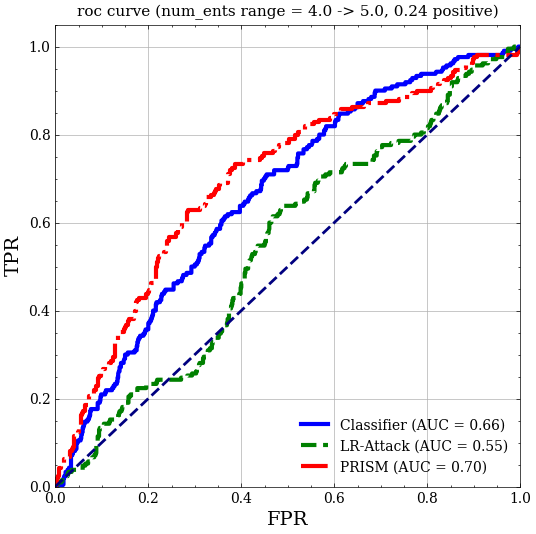

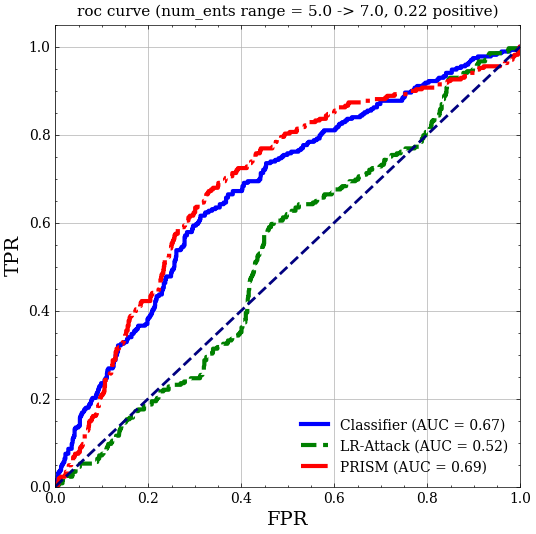

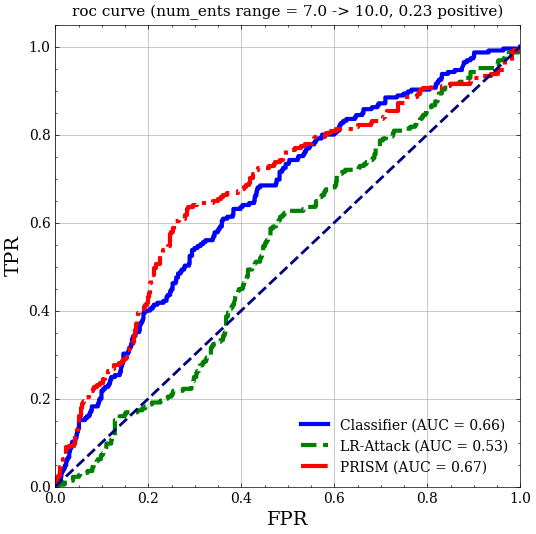

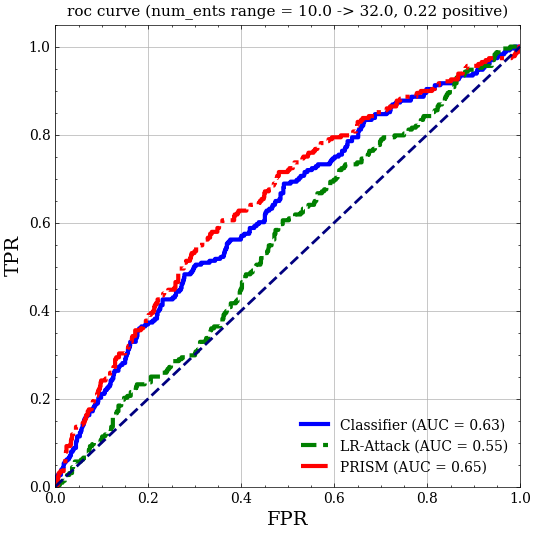

In [26]:
from evaluation.utils import plot_with_ents

for lower_percentile, upper_percentile in zip(percentiles[:-1], percentiles[1:]):
    if lower_percentile != upper_percentile:
        filtered_results = results[(results['num_ents'] >= lower_percentile) & (results['num_ents'] < upper_percentile)]
        plot_with_ents(filtered_results, f"{lower_percentile} -> {upper_percentile}")
    else:
        filtered_results = results[results['num_ents'] == lower_percentile]
        plot_with_ents(filtered_results, f"{lower_percentile}")


## For llama 1 epoch, 25%

In [27]:
results_25 = pd.read_csv('cache/medical_25_llama_1_epoch_results.csv')

In [28]:
X = results_25[['target', 'world_model', 'shadow_model']]
y = results_25['label']

eval_results, model = run_evaluation_pipeline(X, y)
results_25['y_pred_model'] = eval_results['y_pred_model']
results_25['y_pred_proba_model'] = eval_results['y_pred_proba_model']
results_25['lr_attack_scores'] = eval_results['lr_attack_scores']
results_25['prism_attack_scores'] = eval_results['prism_attack_scores']
results_25['num_ents'] = results_pre['num_ents']

# get the 0->25th percentile of num ents, 25->50, 50->75, 75->100
percentiles = np.percentile(results['num_ents'], [0, 25, 50, 75, 100])
percentiles
for lower_percentile, upper_percentile in zip(percentiles[:-1], percentiles[1:]):
    print(f"Percentile range: {lower_percentile} to {upper_percentile}")

Accuracy: 0.7736442211598196 +/- 0.005652307247913072
F1: 0.21005322186925132 +/- 0.023270350575343837
ROC AUC (model): 0.6111644133210505
Percentile range: 4.0 to 5.0
Percentile range: 5.0 to 7.0
Percentile range: 7.0 to 10.0
Percentile range: 10.0 to 32.0


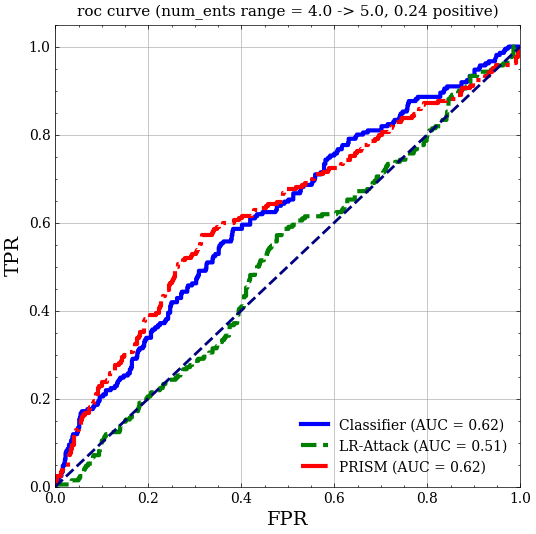

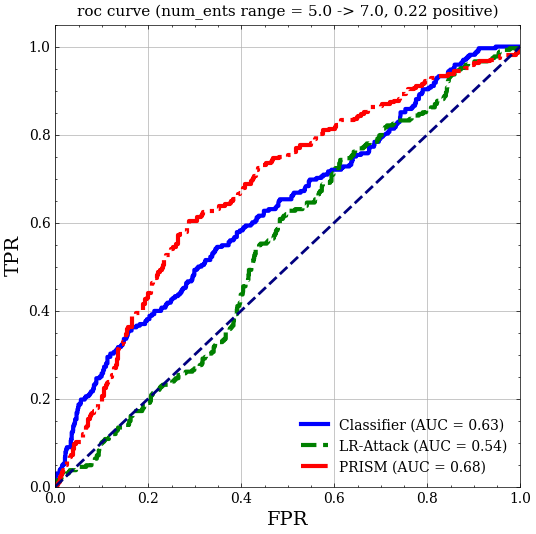

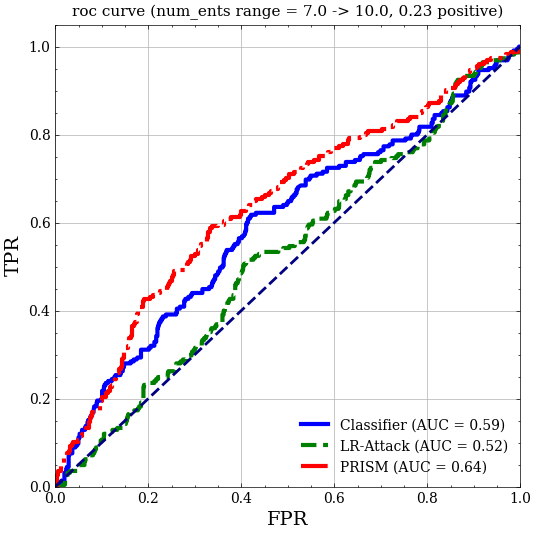

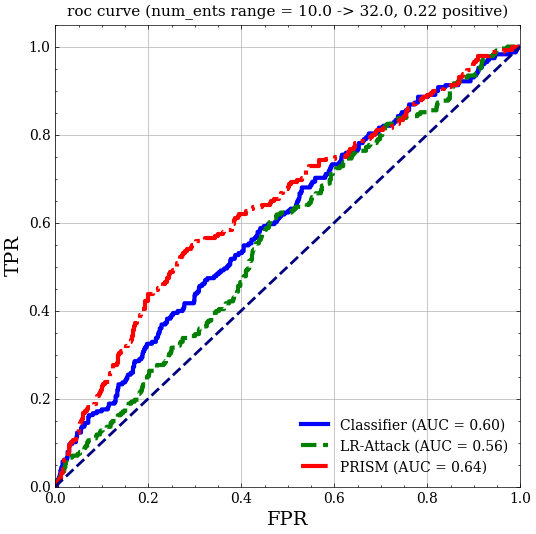

In [29]:
from evaluation.utils import plot_with_ents

for lower_percentile, upper_percentile in zip(percentiles[:-1], percentiles[1:]):
    if lower_percentile != upper_percentile:
        filtered_results = results_25[(results_25['num_ents'] >= lower_percentile) & (results_25['num_ents'] < upper_percentile)]
        plot_with_ents(filtered_results, f"{lower_percentile} -> {upper_percentile}")
    else:
        filtered_results = results_25[results_25['num_ents'] == lower_percentile]
        plot_with_ents(filtered_results, f"{lower_percentile}")


## Plotting for fixed numbers of ents

Ents: 4


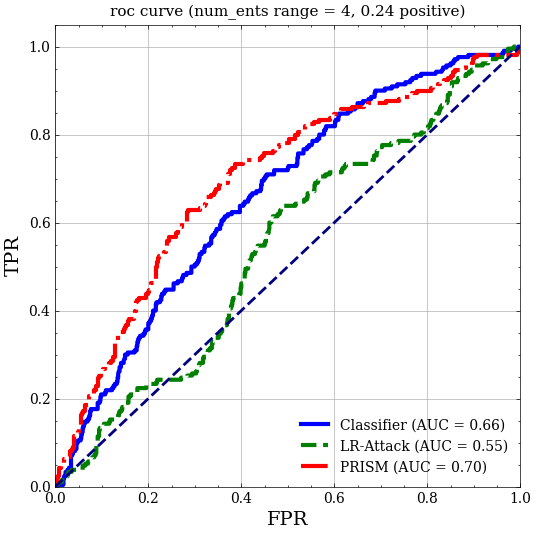

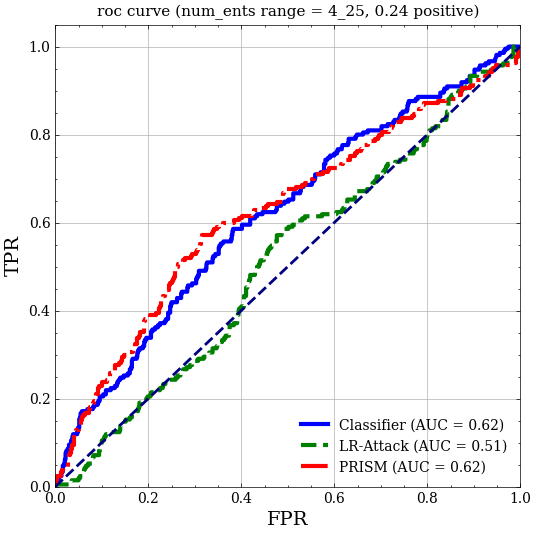




Ents: 5


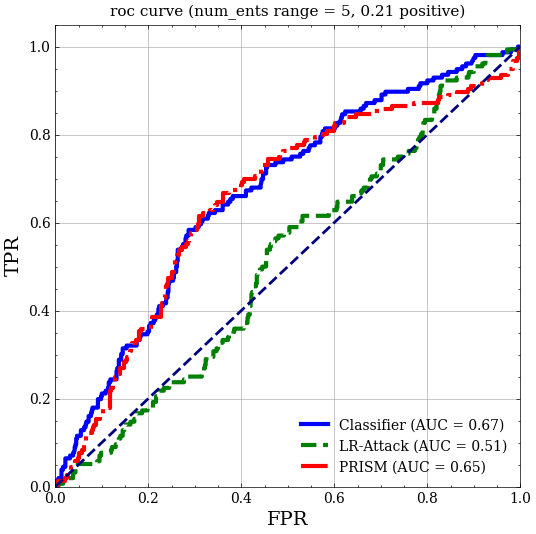

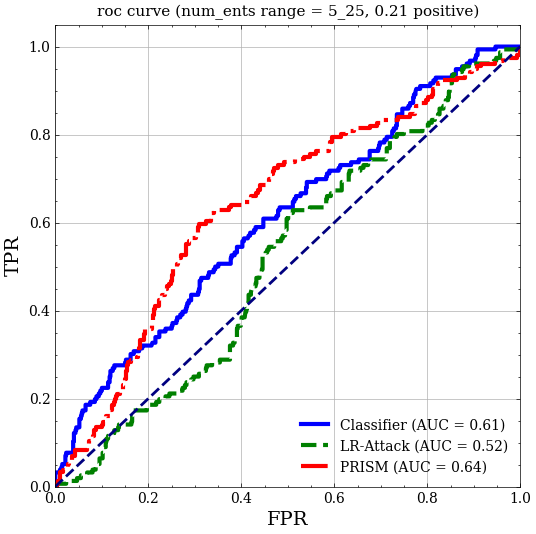




Ents: 6


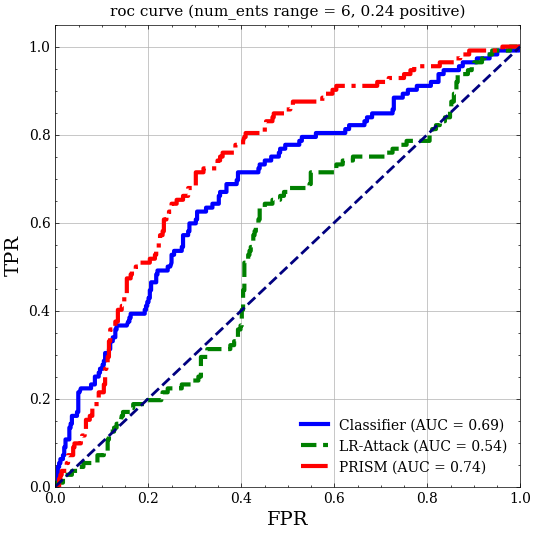

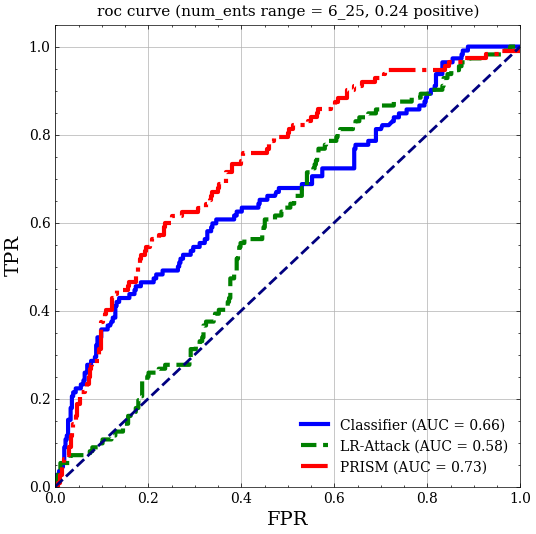




Ents: 7


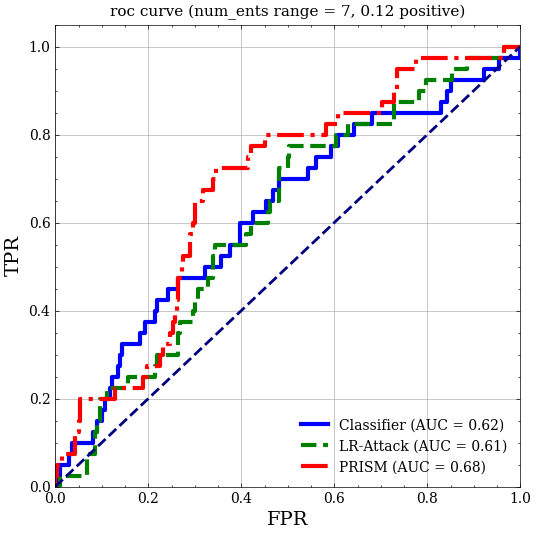

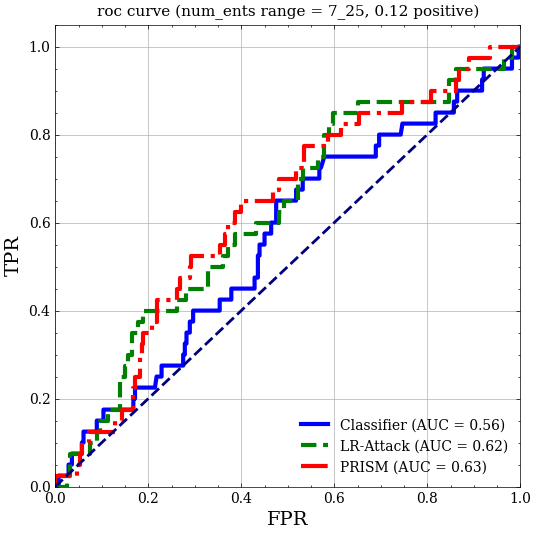




Ents: 8


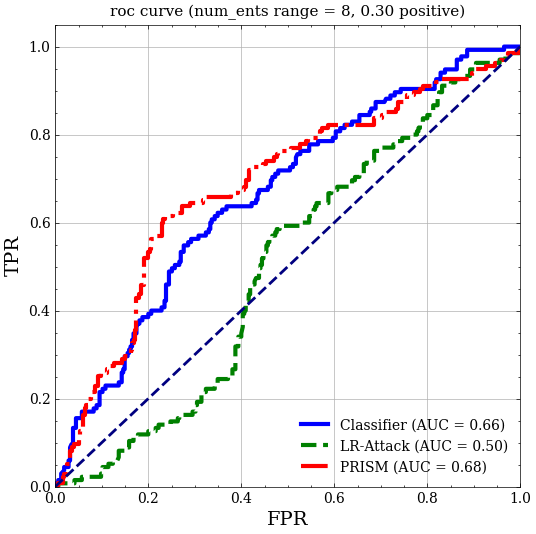

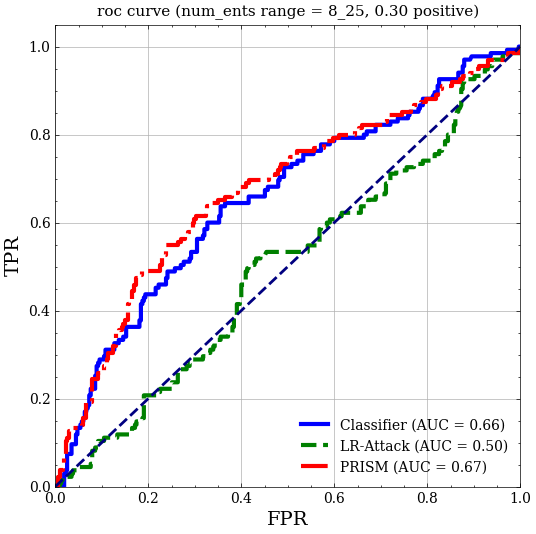




Ents: 9


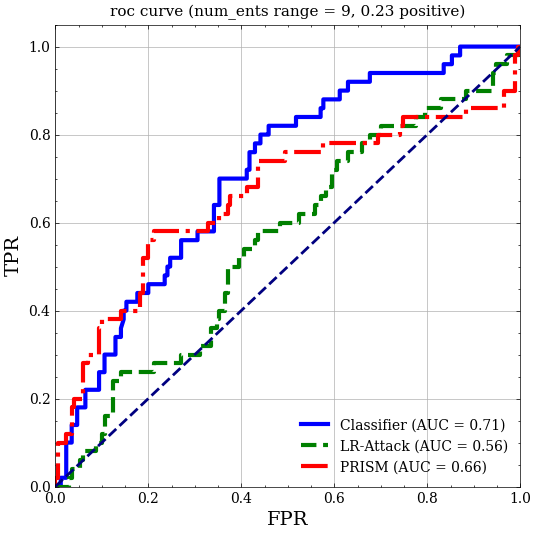

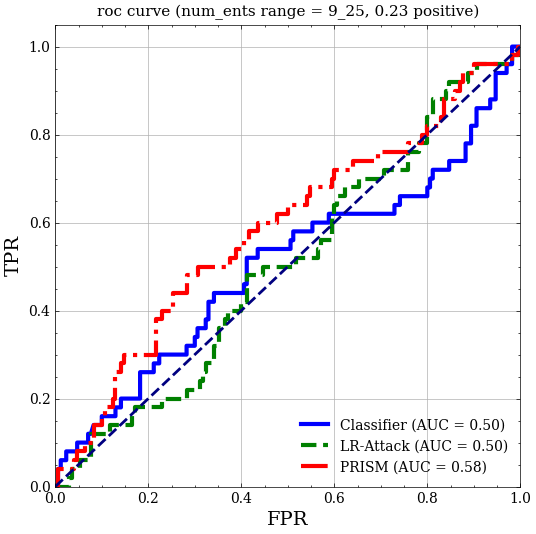




Ents: 10


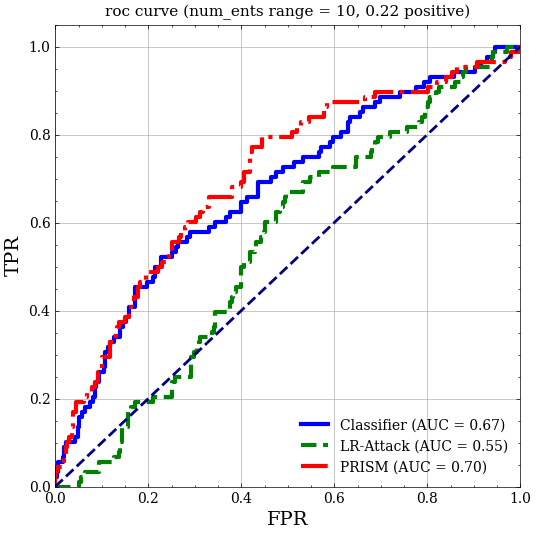

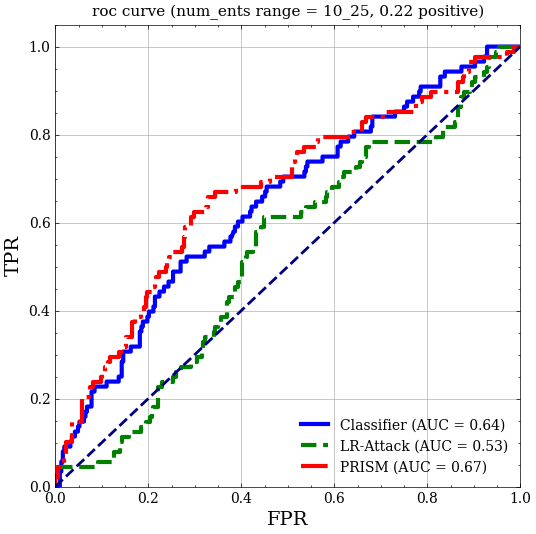




Ents: 11


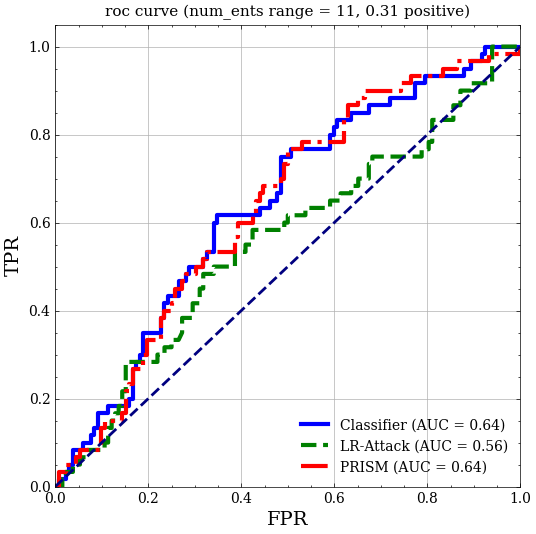

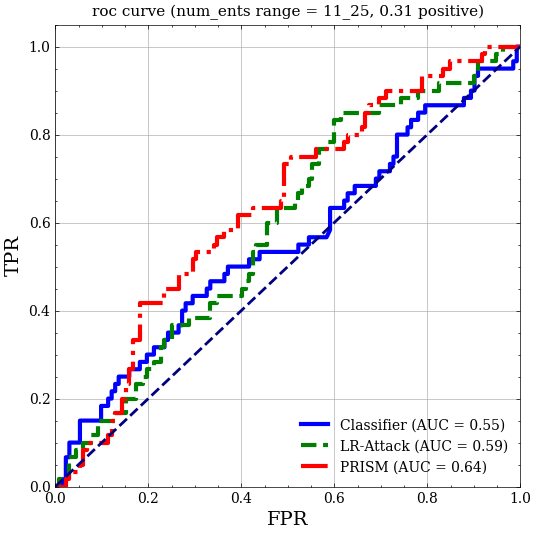




Ents: 12


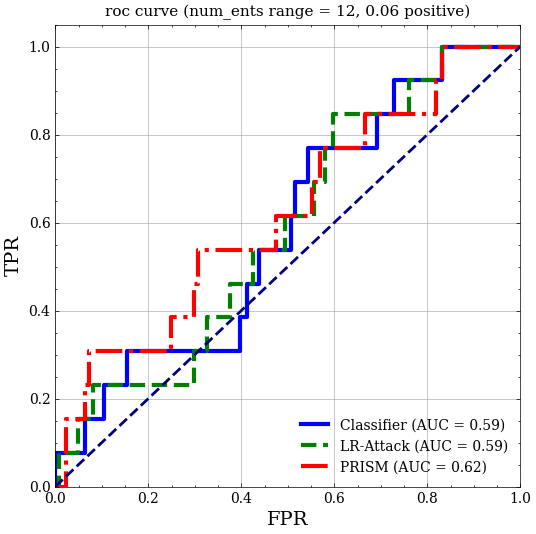

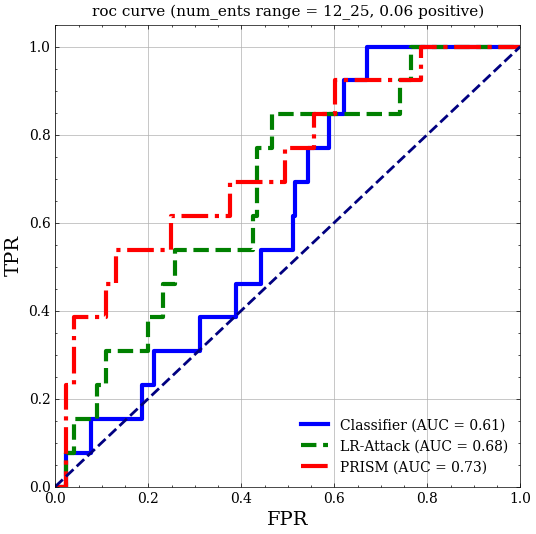

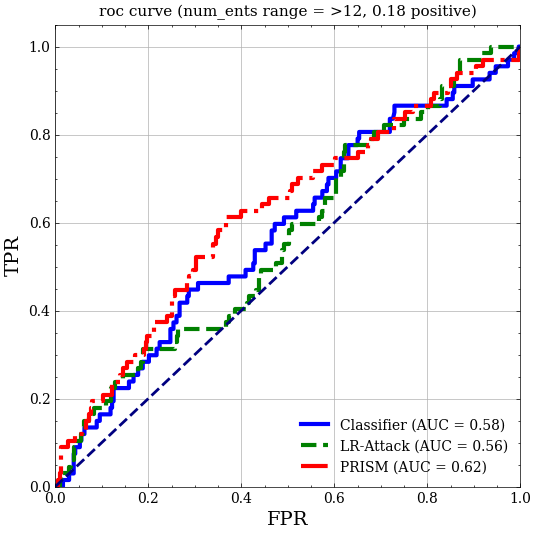

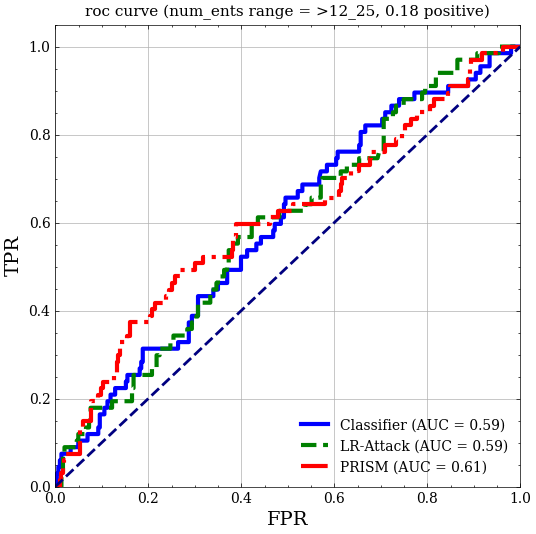

In [32]:
# plot for ents = [5,6,7,8,9,10,11,12]
ents = [4,5,6,7,8,9,10,11,12]

for ent in ents:
    print(f"Ents: {ent}")
    filtered_results = results[results['num_ents'] == ent]
    plot_with_ents(filtered_results, f"{ent}")

    filtered_results = results_25[results_25['num_ents'] == ent]
    plot_with_ents(filtered_results, f"{ent}_25")
    print("\n\n")

# also plot for ents > 12
filtered_results = results[results['num_ents'] > 12]
plot_with_ents(filtered_results, f">12")

filtered_results = results_25[results_25['num_ents'] > 12]
plot_with_ents(filtered_results, f">12_25")